At `ifarm:w/batch/e1f_sim`, the following was executed (and similarly for e16):

```
python h6_top1_from_top123.py -t "h10_eid_efid_hfid_mmp/h10" -o e1f_sim_skim_small_top123_top1.root -i "*_skim_small.root" -w /volatile/clas/clase1/ephelps/phys-ana-omega/e1f6 -c /volatile/clas/clase1/ephelps/phys-ana-omega/e1f6/input.e1f.sim.parms
```

`h6_top1_fromm_top123.py` is like skim_small_sim.py but assumes that `skim_small_sim.py` was already run with the top123 (all topologies) version of `DH_MMp_Exclusive`.  In the future top1 (ppip) is the default topology of `DH_MMp_Exlusive`.

```
    handlers = [("mon_top123", r.DH_Hists_Monitor),
                ("h10_top123", r.DH_CloneH10),
                ("top1", r.DH_MMp_Exclusive),
                ("mon_top123_top1", r.DH_Hists_Monitor),
                ("h6recon_top123_top1", r.DH_H6Maker_Recon)
               ]
```

In [1]:
%matplotlib inline
%run util_draw.py
from array import array
import rootpy as rpy
import rootpy.plotting.root2matplotlib as rplt
from rootpy.io import root_open
import numpy as np
import pandas as pd
import ROOT
import math

In [2]:
fn_e16_all = '../e1f6/test/e16_sim_hists_only.root'
fn_e16_t1 = '../e1f6/test/e16_sim_skim_small_top123_top1_hists_only.root'
fn_e1f_all = '../e1f6/test/e1f_sim_hists_only.root'
fn_e1f_t1 = '../e1f6/test/e1f_sim_skim_small_top123_top1_hists_only.root'
dir_h6t = 'h6thrown'
dir_h6r = 'h6recon_top123_top1'
name_h6 = 'hbd_yield'

def get_edges(h4, dim):
    for ibin in range(1, h4.GetAxis(dim).GetNbins()+1):
        L = h4.GetAxis(dim).GetBinLowEdge(ibin)
        H = h4.GetAxis(dim).GetBinUpEdge(ibin)
        yield (ibin, L, H)

def get_q2w(fn=fn_e1f_t1, dstr='mon_top123_top1'):
    with root_open(fn) as fin:
        d = fin[dstr]
        h2sum = None
        for s,h2 in zip(range(1,7), [d['hq2_V_w_%d'%(s)] for s in range(1,7)]):
            if s == 1:
                h2sum = h2.Clone('hq2_V_w')
            else:
                h2sum.Add(h2)
        h2sum.SetDirectory(0)
        return h2sum

def get_2d(h4, xbin, ybin):
    h4.GetAxis(0).SetRange(xbin, xbin)
    h4.GetAxis(1).SetRange(ybin, ybin)
    h2 = h4.Projection(2,3)
    h2.SetDirectory(0)
    return h2

def get_h4(fh6, dh6, nh6):
    h6 = fh6[dh6][nh6]
    h4_dims = [dimW, dimQ2, dimCosTheta, dimPhi] = [0, 1, 3, 4]
    for i in range(0,6):
        h6.GetAxis(i).SetRange(1, h6.GetAxis(i).GetNbins())
    h4 = h6.ProjectionND(4, array('i', h4_dims))
    return h4

        
def get_h4acc(f_all, f_t1, d_h6t=dir_h6t, d_h6r=dir_h6r, nm_h6=name_h6):
    h6t = f_all[dir_h6t][name_h6]
    h6r = f_t1[dir_h6r][name_h6]
    h4_dims = [dimW, dimQ2, dimCosTheta, dimPhi] = [0, 1, 3, 4]
    for i in range(0,6):
        h6t.GetAxis(i).SetRange(1, h6t.GetAxis(i).GetNbins())
        h6r.GetAxis(i).SetRange(1, h6r.GetAxis(i).GetNbins())
    h4t = h6t.ProjectionND(4, array('i', h4_dims))
    h4r = h6r.ProjectionND(4, array('i', h4_dims))
    h4t.SetName('h4t')
    h4r.SetName('h4r')
    h4a = h4r.Clone('h4a')
    h4t.Sumw2()
    h4r.Sumw2()
    h4a.Sumw2()
    h4a.Divide(h4t)
    return (h4t, h4r, h4a)

def get_h2acc(W, Q2, f_all, f_t1,
              d_h6t=dir_h6t, d_h6r=dir_h6r, nm_h6=name_h6):
    h6t = f_all[dir_h6t][name_h6]
    h6r = f_t1[dir_h6r][name_h6]
    for i in range(0,6):
        h6t.GetAxis(i).SetRange(1, h6t.GetAxis(i).GetNbins())
        h6r.GetAxis(i).SetRange(1, h6r.GetAxis(i).GetNbins())
    dimW, dimQ2, dimCosTheta, dimPhi = 0, 1, 3, 4
    binW = h6t.GetAxis(dimW).FindBin(W)
    binQ2 = h6t.GetAxis(dimQ2).FindBin(Q2)
    Wlo = 1000*h6t.GetAxis(dimW).GetBinLowEdge(binW)
    Whi = 1000*h6t.GetAxis(dimW).GetBinUpEdge(binW)
    Q2lo = 1000*h6t.GetAxis(dimQ2).GetBinLowEdge(binQ2)
    Q2hi = 1000*h6t.GetAxis(dimQ2).GetBinUpEdge(binQ2)
    for h6 in [h6t, h6r]:
        h6.GetAxis(dimW).SetRange(binW, binW)
        h6.GetAxis(dimQ2).SetRange(binQ2, binQ2)
    for h6 in [h6t, h6r]:
        for i in range(0,6):
            if i not in [dimW, dimQ2, dimCosTheta, dimPhi]:
                h6.GetAxis(i).SetRange(1, h6.GetAxis(i).GetNbins())
    h2t = h6t.Projection(dimCosTheta, dimPhi)
    h2r = h6r.Projection(dimCosTheta, dimPhi)
    h2t.SetName('h2t_%d_%d_%d_%d'%(Wlo, Whi, Q2lo, Q2hi))
    h2r.SetName('h2r_%d_%d_%d_%d'%(Wlo, Whi, Q2lo, Q2hi))
    h2a = h2r.Clone('h2a_%d_%d_%d_%d'%(Wlo, Whi, Q2lo, Q2hi))
    h2a.Divide(h2t)
    for h2 in [h2t, h2r, h2a]:
        h2.SetDirectory(0)
    return (h2t, h2r, h2a)

In [3]:
h4e1f_e = get_h4(root_open('../e1f6/test/h6_top1_e1f_exp.root'), 'h6_mmp_top1', 'hbd_yield')
h4e16_e = get_h4(root_open('../e1f6/test/h6_top1_e16_exp.root'), 'h6_mmp_top1', 'hbd_yield')

In [16]:
h4t_e1f, h4r_e1f, h4a_e1f = get_h4acc(root_open(fn_e1f_all), root_open(fn_e1f_t1))
h4t_e16, h4r_e16, h4a_e16 = get_h4acc(root_open(fn_e16_all), root_open(fn_e16_t1))

In [11]:
def deactivate_bins(h, vlow=None, vhigh=None):
    for b in h:
        if (vlow is not None and b.value <= vlow) or \
           (vhigh is not None and b.value >= vhigh):
            b.value = np.nan
            b.error = np.nan


def get_mask(h, vlow=None, vhigh=None, errors=False):
    _h = h.Clone()
    if not errors:
        for ibin in range(0, _h.GetNbins()):
            val = _h.GetBinContent(ibin)
            if (vlow is not None and val <= vlow) or \
               (vhigh is not None and val >= vhigh):
                _h.SetBinContent(ibin, 0)
            else:
                _h.SetBinContent(ibin, 1)
    else:
        _h.Sumw2()
        for ibin in range(0, _h.GetNbins()):
            val = _h.GetBinContent(ibin)
            err = math.sqrt(_h.GetBinError2(ibin))
            if (vlow is not None and (val == 0 or err/val <= vlow)) or \
               (vhigh is not None and (val == 0 or err/val >= vhigh)):
                _h.SetBinContent(ibin, 0)
            else:
                _h.SetBinContent(ibin, 1)
    return _h

def umask(h):
    _h = h.Clone()
    for ibin in range(0, _h.GetNbins()):
        val = _h.GetBinContent(ibin)
        if val == 0:
            _h.SetBinContent(ibin, 1)
        else:
            _h.SetBinContent(ibin, 0)
    return _h

# def get_mask(h, vlow=None, vhigh=None, errors=False):
#     _h = h.clone()
#     if not errors:
#         for b in _h:
#             if (vlow is not None and b.value <= vlow) or \
#                (vhigh is not None and b.value >= vhigh):
#                 b.value = np.nan
#             else:
#                 b.value = 1
#     else:
#         for b in _h:
#             if (vlow is not None and (b.value==0 or b.error/math.fabs(b.value) <= vlow)) or \
#                (vhigh is not None and (b.value==0 or b.error/math.fabs(b.value) >= vhigh)):
#                 b.value = np.nan
#             else:
#                 b.value = 1
#     return _h


def mdraw2d(hists, rows=2, cols=3, xlabel='', ylabel='',
            xlims=None, ylims=None, vmin=None, vmax=None,
            space=0, grid=False, figsize=None, **kwargs):
    nr, nc = rows, cols
    if figsize is None:
        figsize=goldenaspect(6.5,nr,nc)
    fig = plt.figure(figsize=figsize)
    gs = gridspec.GridSpec(nr, nc, wspace=space, hspace=2*space, left=0.1, right=0.95, bottom=0.175)
    im = None
    vmax = 0.9*max([h.GetMaximum() for h in hists]) if vmax is None else vmax
    for irow in range(0,nr):
        for icol in range(0,nc):
            hnum = nc*irow+(icol+1)
            h = hists[hnum-1]
            ax = plt.subplot(gs[irow, icol])
            im = rplt.imshow(asrootpy(h), axes=ax, vmin=vmin, vmax=vmax, **kwargs)
#             rplt.hist2d(h, axes=ax, **kwargs) #, norm=LogNorm())
            if xlims is not None:
                plt.xlim(xlims)
            if ylims is not None:
                plt.ylim(ylims)
            if icol > 0:
                ax.set_yticklabels('')
            if irow+1 < nr:
                ax.set_xticklabels('')
            if grid is True:
                plt.grid()
    fig.add_axes([0.06, 0.105, 0.94, 0.895], frameon=False)
    plt.xticks([])
    plt.yticks([])
    plt.ylabel(ylabel)
    plt.xlabel(xlabel)
#     fig.subplots_adjust(right=0.8)
    cbar_ax = fig.add_axes([0.975, 0.2, 0.02, 0.7])
    fig.colorbar(im, cax=cbar_ax)
    return fig

23634.0


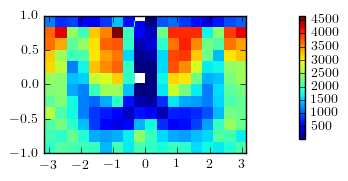

9450.0


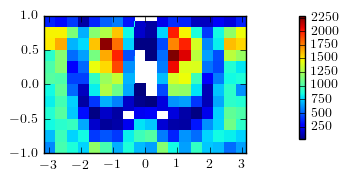

In [8]:
binW = h4e1f_e.GetAxis(0).FindBin(2)
binQ2 = h4e1f_e.GetAxis(1).FindBin(2)
h2 = asrootpy(get_2d(h4e1f_e, binW, binQ2))
print(h2.GetEntries())
h2.Scale(1, 'width')
deactivate_bins(h2, vlow=0)
fig = draw(h2)
im = rplt.imshow(asrootpy(h2), axes=fig.get_axes()[0])
fig.subplots_adjust(right=0.8)
cbar_ax = fig.add_axes([0.975, 0.2, 0.02, 0.7])
fig.colorbar(im, cax=cbar_ax)
plt.show()
# fig2 = draw(asrootpy(h2.ProjectionX()))
binW = h4e16_e.GetAxis(0).FindBin(2)
binQ2 = h4e16_e.GetAxis(1).FindBin(2)
h2 = asrootpy(get_2d(h4e16_e, binW, binQ2))
print(h2.GetEntries())
h2.Scale(1, 'width')
deactivate_bins(h2, vlow=0)
fig = draw(h2)
im = rplt.imshow(asrootpy(h2), axes=fig.get_axes()[0])
fig.subplots_adjust(right=0.8)
cbar_ax = fig.add_axes([0.975, 0.2, 0.02, 0.7])
fig.colorbar(im, cax=cbar_ax)
plt.show()

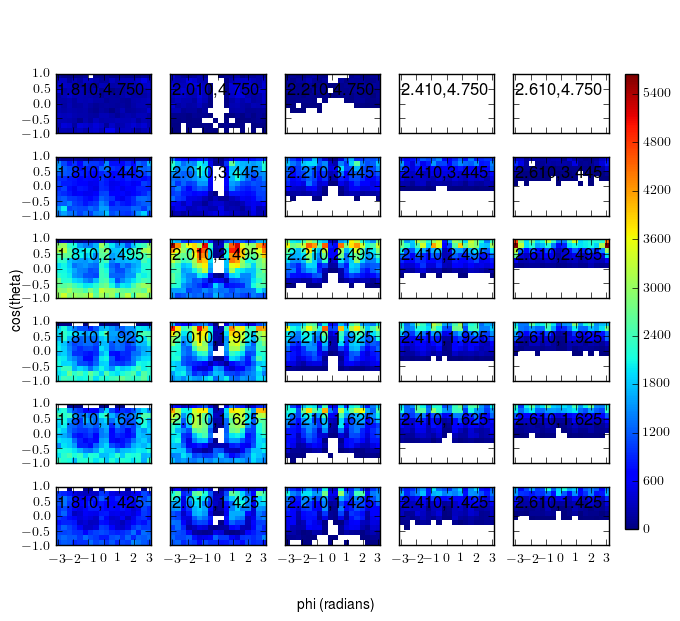

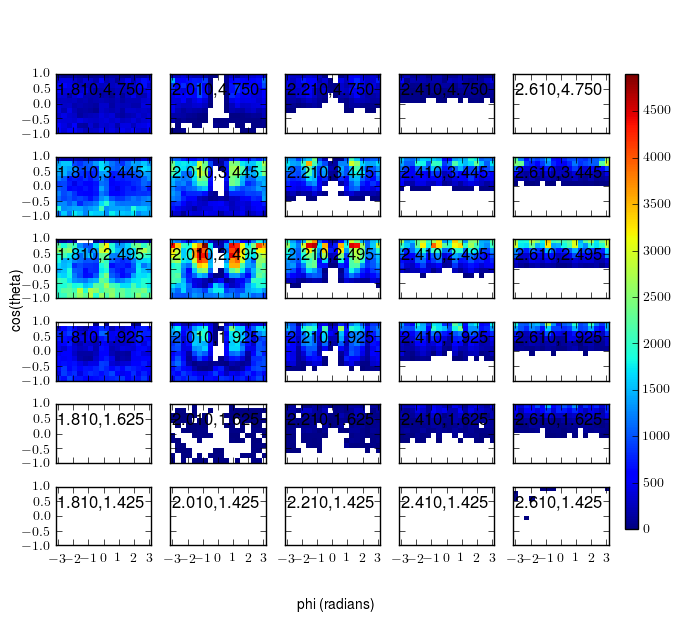

In [12]:
h4 = h4e1f_e #h4a_e1f_masked
h2s = []
wq2s = []
for (binQ2, Q2lo, Q2hi) in reversed(list(get_edges(h4, 1))):
#     print(binQ2, Q2lo, Q2hi)
    for (binW, Wlo, Whi) in [(binW, Wlo, Whi) for (binW, Wlo, Whi) in get_edges(h4, 0) if binW>10 and (binW-1)%10==0 and binW<57]:
#         print('   %d,%.3f,%.3f'%(binW, Wlo, Whi))
        h2 = asrootpy(get_2d(h4, binW, binQ2))
        for b in h2:
            if b.value==0: b.value=np.nan
        h2.Scale(1,"width")
        h2s.append(h2)
        Q2mid, Wmid = (Q2lo+Q2hi)/2.0, (Wlo+Whi)/2.0
        wq2s.append('%.3f,%.3f'%(Wmid, Q2mid))
cols = int((len(h2s)+5)/6)
fig = mdraw2d(h2s, cols=cols, rows=6, space=0.2,
              vmin=0, figsize=(6.5, 6.5),
              ylabel=r'cos(#theta)', xlabel=r'#phi (radians)')
for iax, h2 in enumerate(h2s):
    ax = fig.get_axes()[iax]
    ax.text(-3, 0.3, '%s'%wq2s[iax], color='k', fontsize=12)
plt.show()

h4 = h4e16_e #h4a_e1f_masked
h2s = []
wq2s = []
for (binQ2, Q2lo, Q2hi) in reversed(list(get_edges(h4, 1))):
#     print(binQ2, Q2lo, Q2hi)
    for (binW, Wlo, Whi) in [(binW, Wlo, Whi) for (binW, Wlo, Whi) in get_edges(h4, 0) if binW>10 and (binW-1)%10==0 and binW<57]:
#         print('   %d,%.3f,%.3f'%(binW, Wlo, Whi))
        h2 = asrootpy(get_2d(h4, binW, binQ2))
        for b in h2:
            if b.value==0: b.value=np.nan
        h2.Scale(1,"width")
        h2s.append(h2)
        Q2mid, Wmid = (Q2lo+Q2hi)/2.0, (Wlo+Whi)/2.0
        wq2s.append('%.3f,%.3f'%(Wmid, Q2mid))
cols = int((len(h2s)+5)/6)
fig = mdraw2d(h2s, cols=cols, rows=6, space=0.2,
              vmin=0, figsize=(6.5, 6.5),
              ylabel=r'cos(#theta)', xlabel=r'#phi (radians)')
for iax, h2 in enumerate(h2s):
    ax = fig.get_axes()[iax]
    ax.text(-3, 0.3, '%s'%wq2s[iax], color='k', fontsize=12)
plt.show()

In [34]:
h4a_e1f_masks = get_mask(h4a_e1f, vhigh=0.1, errors=True)
h4a_e1f_masked = h4a_e1f.Clone("h4a_e1f_masked")
h4a_e1f_masked.Divide(h4a_e1f_masks)
binW = h4a_e1f_masked.GetAxis(0).FindBin(2)
binQ2 = h4a_e1f_masked.GetAxis(1).FindBin(2)
h2 = asrootpy(get_2d(h4a_e1f_masked, binW, binQ2))
deactivate_bins(h2, vlow=0)
fig = draw(h2)

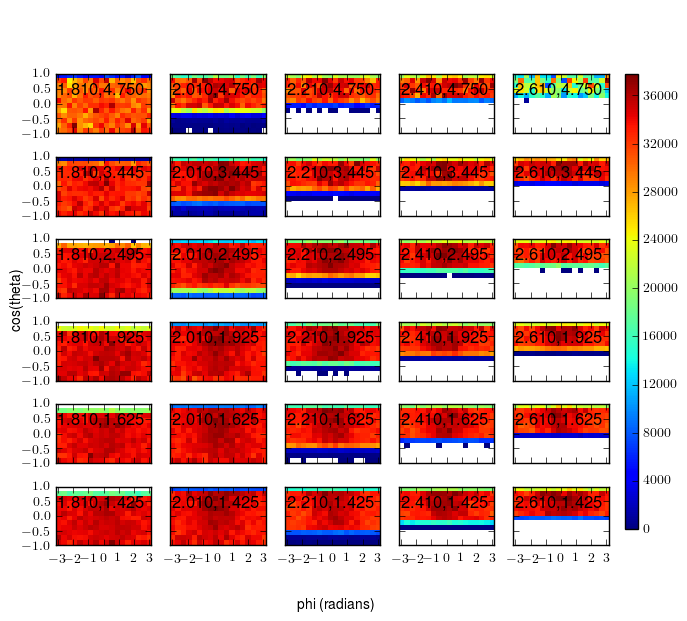

/home/ephelps/projects/anaconda2/envs/root6_py3/lib/python3.4/site-packages/numpy/ma/core.py:4144: UserWarning: Warning: converting a masked element to nan.
  warnings.warn("Warning: converting a masked element to nan.")


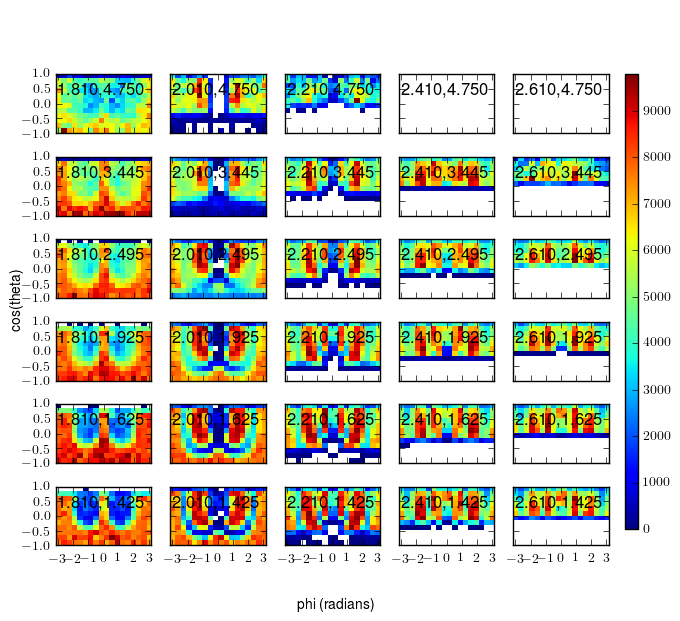

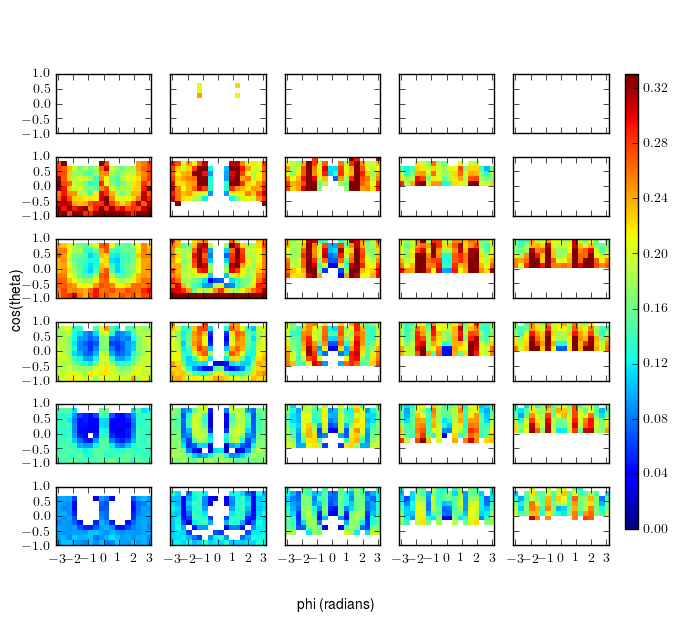

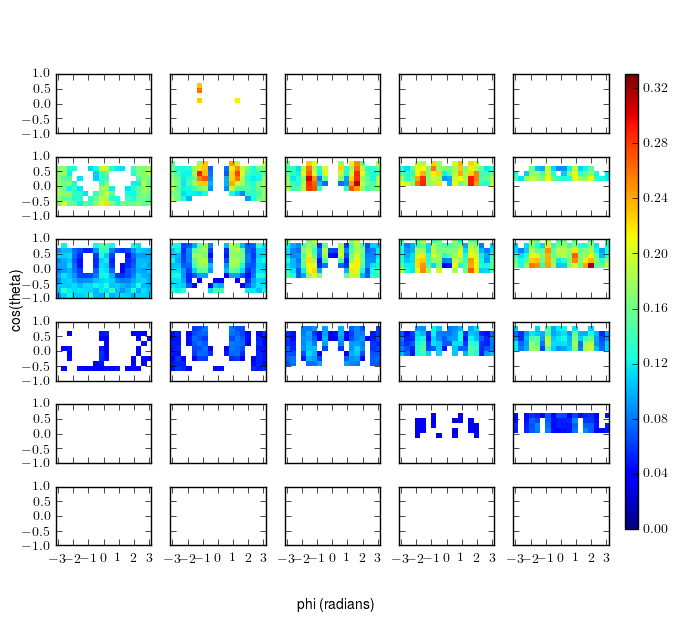

In [50]:
h4a_e1f_masks = get_mask(h4a_e1f, vhigh=0.1, errors=True)
h4a_e1f_masked = h4a_e1f.Clone("h4a_e1f_masked")
h4a_e1f_masked.Divide(h4a_e1f_masks)
h4a_e16_masks = get_mask(h4a_e16, vhigh=0.1, errors=True)
h4a_e16_masked = h4a_e16.Clone("h4a_e16_masked")
h4a_e16_masked.Divide(h4a_e16_masks)

h4 = h4t_e1f #h4a_e1f_masked
h2s = []
wq2s = []
for (binQ2, Q2lo, Q2hi) in reversed(list(get_edges(h4, 1))):
#     print(binQ2, Q2lo, Q2hi)
    for (binW, Wlo, Whi) in [(binW, Wlo, Whi) for (binW, Wlo, Whi) in get_edges(h4, 0) if binW>10 and (binW-1)%10==0 and binW<57]:
#         print('   %d,%.3f,%.3f'%(binW, Wlo, Whi))
        h2 = asrootpy(get_2d(h4, binW, binQ2))
        for b in h2:
            if b.value==0: b.value=np.nan
        h2.Scale(1,"width")
        h2s.append(h2)
        Q2mid, Wmid = (Q2lo+Q2hi)/2.0, (Wlo+Whi)/2.0
        wq2s.append('%.3f,%.3f'%(Wmid, Q2mid))
cols = int((len(h2s)+5)/6)
fig = mdraw2d(h2s, cols=cols, rows=6, space=0.2,
              vmin=0, figsize=(6.5, 6.5),
              ylabel=r'cos(#theta)', xlabel=r'#phi (radians)')
for iax, h2 in enumerate(h2s):
    ax = fig.get_axes()[iax]
    ax.text(-3, 0.3, '%s'%wq2s[iax], color='k', fontsize=12)
plt.show()

h4 = h4r_e1f #h4a_e1f_masked
h2s = []
wq2s = []
for (binQ2, Q2lo, Q2hi) in reversed(list(get_edges(h4, 1))):
#     print(binQ2, Q2lo, Q2hi)
    for (binW, Wlo, Whi) in [(binW, Wlo, Whi) for (binW, Wlo, Whi) in get_edges(h4, 0) if binW>10 and (binW-1)%10==0 and binW<57]:
#         print('   %d,%.3f,%.3f'%(binW, Wlo, Whi))
        h2 = asrootpy(get_2d(h4, binW, binQ2))
        for b in h2:
            if b.value==0: b.value=np.nan
        h2.Scale(1,"width")
        h2s.append(h2)
        Q2mid, Wmid = (Q2lo+Q2hi)/2.0, (Wlo+Whi)/2.0
        wq2s.append('%.3f,%.3f'%(Wmid, Q2mid))
cols = int((len(h2s)+5)/6)
fig = mdraw2d(h2s, cols=cols, rows=6, space=0.2,
              vmin=0, figsize=(6.5, 6.5),
              ylabel=r'cos(#theta)', xlabel=r'#phi (radians)')
for iax, h2 in enumerate(h2s):
    ax = fig.get_axes()[iax]
    ax.text(-3, 0.3, '%s'%wq2s[iax], color='k', fontsize=12)
plt.show()

h4 = h4a_e1f_masked #h4a_e1f_masked
h2s = []
for (binQ2, Q2lo, Q2hi) in reversed(list(get_edges(h4, 1))):
#     print(binQ2, Q2lo, Q2hi)
    for (binW, Wlo, Whi) in [(binW, Wlo, Whi) for (binW, Wlo, Whi) in get_edges(h4, 0) if binW>10 and (binW-1)%10==0 and binW<57]:
#         print('   %d,%.3f,%.3f'%(binW, Wlo, Whi))
        h2 = asrootpy(get_2d(h4, binW, binQ2))
        for b in h2:
            if b.value==0: b.value=np.nan
        h2s.append(h2)
cols = int((len(h2s)+5)/6)
fig = mdraw2d(h2s, cols=cols, rows=6, space=0.2,
              vmin=0, vmax=0.33, figsize=(6.5, 6.5),
              ylabel=r'cos(#theta)', xlabel=r'#phi (radians)')
plt.show()

h4 = h4a_e16_masked #h4a_e1f_masked
h2s = []
for (binQ2, Q2lo, Q2hi) in reversed(list(get_edges(h4, 1))):
#     print(binQ2, Q2lo, Q2hi)
    for (binW, Wlo, Whi) in [(binW, Wlo, Whi) for (binW, Wlo, Whi) in get_edges(h4, 0) if binW>10 and (binW-1)%10==0 and binW<57]:
#         print('   %d,%.3f,%.3f'%(binW, Wlo, Whi))
        h2 = asrootpy(get_2d(h4, binW, binQ2))
        for b in h2:
            if b.value==0: b.value=np.nan
        h2s.append(h2)
cols = int((len(h2s)+5)/6)
fig = mdraw2d(h2s, cols=cols, rows=6, space=0.2,
              vmin=0, vmax=0.33, figsize=(6.5, 6.5),
              ylabel=r'cos(#theta)', xlabel=r'#phi (radians)')

# fig = mdraw(h2s, 5,6, vmin=0.02, vmax=0.35)
# for iax, h2 in enumerate(h2s):
#     ax = fig.get_axes()[iax]
#     im = rplt.imshow(asrootpy(h2), axes=ax, vmin=acc_cutoff, vmax=0.35)
# fig.subplots_adjust(right=0.8)
# cbar_ax = fig.add_axes([0.85, 0.15, 0.05, 0.7])
# fig.colorbar(im, cax=cbar_ax)
# plt.show()

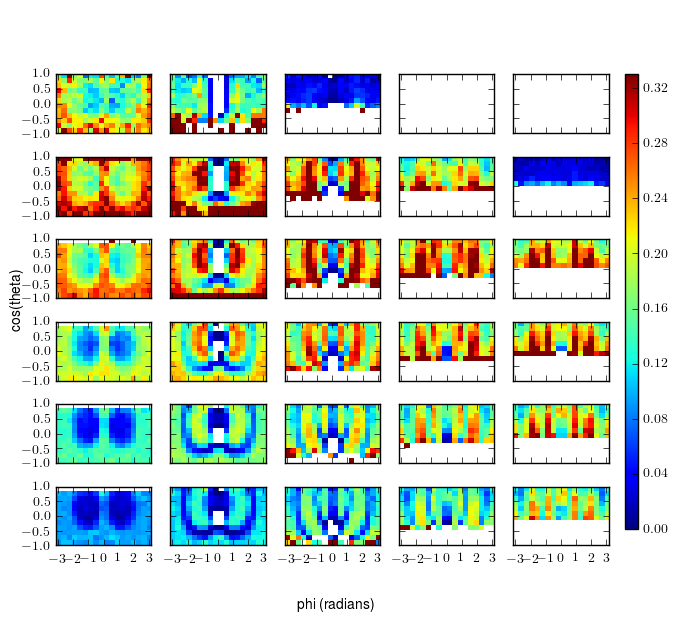

In [222]:
h2_masks = []
for h2 in h2s:
    h2_masks.append(get_mask(h2, 0.002))

h2s_masked = [h2*h2m for (h2,h2m) in zip(h2s, h2_masks)]
fig = mdraw2d(h2s_masked, cols=5, rows=6, space=0.2,
              vmin=0, vmax=0.33, figsize=(6.5, 6.5),
              ylabel=r'cos(#theta)', xlabel=r'#phi (radians)')

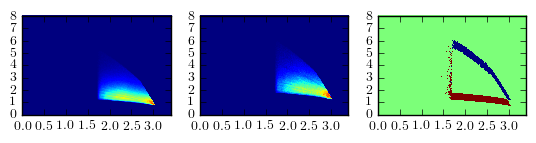

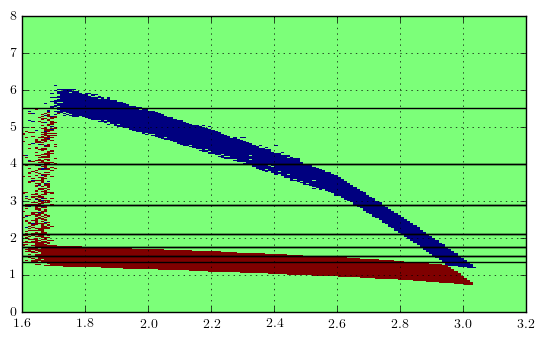

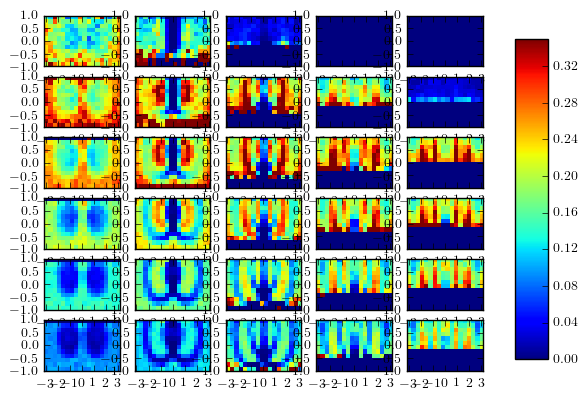

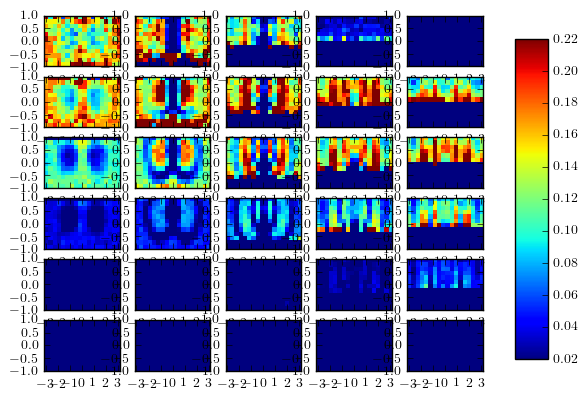

In [205]:
acc_cutoff = 0.00
hq2w = asrootpy(get_q2w())
hq2wb = asrootpy(get_q2w(fn_e16_t1))
# hq2w_n = norm_x_slices(norm_y_slices(hq2w))
# hq2wb_n = norm_x_slices(norm_y_slices(hq2wb))
hq2w_n = asrootpy(hq2w.Clone('hq2w_n'))
hq2wb_n = asrootpy(hq2wb.Clone('hq2wb_n'))
for b in hq2w_n:
    if b.value>0: b.value=1
for b in hq2wb_n:
    if b.value>0: b.value=1
hq2w_n.Add(hq2wb_n, -1)
mdraw([hq2w, hq2wb, hq2w_n], 3)
plt.show()

fig = plt.figure(figsize=goldenaspect(6.5))
rplt.imshow(asrootpy(hq2w_n))
ax = fig.get_axes()[0]
ax.set_xlim(1.6, 3.2)
for (binQ2, Q2lo, Q2hi) in get_edges(h4r_e16, 1):
    plt.hlines([Q2lo, Q2hi], 1.6, 3.2)
plt.grid()
plt.show()

h2s = []
for (binQ2, Q2lo, Q2hi) in reversed(list(get_edges(h4r_e1f, 1))):
#     print(binQ2, Q2lo, Q2hi)
    for (binW, Wlo, Whi) in [(binW, Wlo, Whi) for (binW, Wlo, Whi) in get_edges(h4r_e1f, 0) if binW>10 and (binW-1)%10==0 and binW<57]:
#         print('   %d,%.3f,%.3f'%(binW, Wlo, Whi))
        h2 = asrootpy(get_2d(h4a_e1f, binW, binQ2))
        for b in h2:
            if b.value<acc_cutoff: b.value=np.nan
        h2s.append(h2)
fig = mdraw(h2s, 5,6, vmin=0.02, vmax=0.35)
for iax, h2 in enumerate(h2s):
    ax = fig.get_axes()[iax]
    im = rplt.imshow(asrootpy(h2), axes=ax, vmin=acc_cutoff, vmax=0.35)
fig.subplots_adjust(right=0.8)
cbar_ax = fig.add_axes([0.85, 0.15, 0.05, 0.7])
fig.colorbar(im, cax=cbar_ax)
plt.show()

h2sb = []
for (binQ2, Q2lo, Q2hi) in reversed(list(get_edges(h4r_e16, 1))):
#     print(binQ2, Q2lo, Q2hi)
    for (binW, Wlo, Whi) in [(binW, Wlo, Whi) for (binW, Wlo, Whi) in get_edges(h4r_e16, 0) if binW>10 and (binW-1)%10==0 and binW<57]:
#         print('   %d,%.3f,%.3f'%(binW, Wlo, Whi))
        h2 = asrootpy(get_2d(h4a_e16, binW, binQ2))
        for b in h2:
            if b.value<acc_cutoff: b.value=np.nan
        h2sb.append(h2)
fig = mdraw(h2sb, 5,6, vmin=acc_cutoff, vmax=0.22)
for iax, h2 in enumerate(h2sb):
    ax = fig.get_axes()[iax]
    im = rplt.imshow(asrootpy(h2), axes=ax, vmin=0.02, vmax=0.22)
fig.subplots_adjust(right=0.8)
cbar_ax = fig.add_axes([0.85, 0.15, 0.05, 0.7])
fig.colorbar(im, cax=cbar_ax)
plt.show()

1721


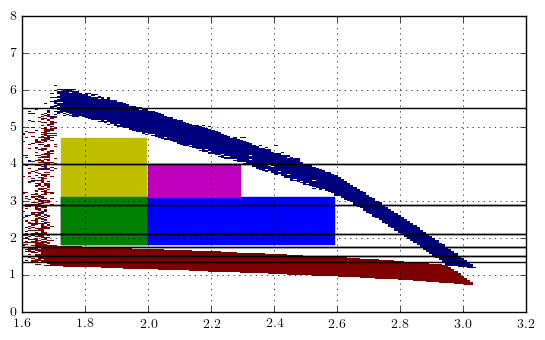

In [138]:
print(783+938)
fig = plt.figure(figsize=goldenaspect(6.5))
cmap = plt.matplotlib.cm.jet
cmap.set_bad('w',1)
for b in hq2w_n:
    if b.value==0: b.value=np.nan
rplt.imshow(asrootpy(hq2w_n), vmin=-1, vmax=1, cmap=cmap)

ax = fig.get_axes()[0]
ax.set_xlim(1.6, 3.2)
for (binQ2, Q2lo, Q2hi) in get_edges(h4r_e16, 1):
    plt.hlines([Q2lo, Q2hi], 1.6, 3.2)
# points = [(1.721, 5.35), (2.6, 3.1), (2.92, 1.35),
#           (2.6, 1.6), (1.701, 1.9), (1.721, 5.35)]
# plt.plot(*zip(*points), color='k', linewidth=2, linestyle='dashed')
# points = [(1.721, 3.1), (2.6, 3.1),
#           (2.6, 1.825), (1.721, 1.825), (1.721, 3.1)]
# plt.plot(*zip(*points), linewidth=2, color='b', alpha=0.5)
# points = [(1.721, 4.7), (2.0, 4.7),
#           (2, 1.825), (1.721, 1.825),#(2, 3.1), (1.721, 3.1),
#           (1.721, 4.7)]
# plt.plot(*zip(*points), linewidth=2, color='y', alpha=0.5)
plt.fill_between(np.arange(1.721, 2.6, 0.01), 1.825, 3.1, color='b') #, alpha=0.5)
plt.fill_between(np.arange(1.721, 2, 0.01), 1.825, 4.7, color='y') #, alpha=0.5)
plt.fill_between(np.arange(1.721, 2, 0.01), 1.825, 3.1, color='g') #, alpha=0.5)
plt.fill_between(np.arange(2, 2.3, 0.01), 3.1, 4, color='m') #, alpha=0.5)
plt.grid()
plt.show()

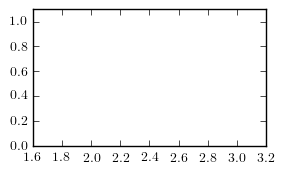

In [10]:
binW = h4a.GetAxis(0).FindBin(2)
binQ2 = h4a.GetAxis(1).FindBin(2.5)
h4t.GetAxis(1).SetRange(0,0) #binQ2, binQ2)
h4r.GetAxis(1).SetRange(0,0) #binQ2, binQ2)
hWt = h4t.Projection(0)
hWr = h4r.Projection(0)
hWa = hWr.Clone('hWa')
hWa.Divide(hWt)
draw(asrootpy(hWa))
plt.ylim(0,1.1)
plt.show()

In [6]:
binW = h4a.GetAxis(0).FindBin(2)
binQ2 = h4a.GetAxis(1).FindBin(2)
h4a.GetAxis(0).SetRange(binW, binW)
h4a.GetAxis(1).SetRange(binQ2, binQ2)
h2_sample = h4a.Projection(2,3)
h2_sample.SetName('h2_sample')
h2_sample.SetDirectory(0)

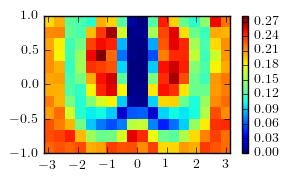

In [7]:
fig = draw(asrootpy(h2_sample))
im = rplt.imshow(asrootpy(h2_sample), colorbar=True) #, norm=LogNorm())

h2a_1880_1900_1750_2100


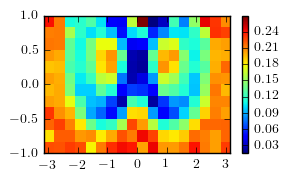

h2a_1980_2000_2100_2890


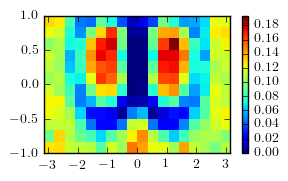

In [21]:
h2t, h2r, h2a = get_h2acc(1.9, 2, root_open(fn_e1f_all), root_open(fn_e1f_t1))
print(h2a.GetName())
draw(asrootpy(h2a))
im = rplt.imshow(asrootpy(h2a), colorbar=True) #, norm=LogNorm())
plt.show()

h2t, h2r, h2a = get_h2acc(2, 2.6, root_open(fn_e16_all), root_open(fn_e16_t1))
print(h2a.GetName())
draw(asrootpy(h2a))
im = rplt.imshow(asrootpy(h2a), colorbar=True) #, norm=LogNorm())
plt.show()

<class 'ROOT.TH2D'>


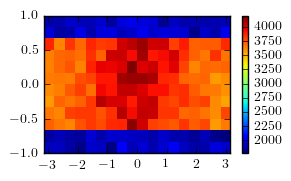

In [17]:
print(type(h2t))
fig = draw(asrootpy(h2t))
im = rplt.imshow(asrootpy(h2t), colorbar=True)

<class 'ROOT.TH2D'>


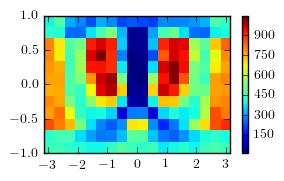

In [18]:
print(type(h2r))
fig = draw(asrootpy(h2r))
im = rplt.imshow(asrootpy(h2r), colorbar=True)

In [21]:
h2t, h2r, h2a = get_h2acc(2.2, 2.2, root_open(fn_e16_all), root_open(fn_e16_t1))
for h2 in [h2t, h2r, h2a]:
    h2.SetDirectory(0)

<class 'ROOT.TH2D'>


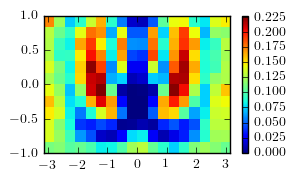

In [22]:
print(type(h2a))
fig = draw(asrootpy(h2a))
im = rplt.imshow(asrootpy(h2a), colorbar=True) #, norm=LogNorm())

In [24]:
h2a.GetName()

'h2a_2_2_2_2'